# **Requirements**

Python 3.8.10

pythonnet 2.5.2

`pip install pythonnet==2.5.2`

In [2]:
# Add this cell at the very top of the notebook (before: `from classes...`)
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parent  # ...\FSO_Project
sys.path.insert(0, str(project_root))

print("Added to sys.path:", project_root)

Added to sys.path: D:\Msc.Photonics\Master_Thesis\FSO_Project


In [3]:
from classes.base_interactive import PythonZOSConnection
from classes.beam_shaper import BeamShaper
import sys
from importlib import metadata
import numpy as np
import matplotlib.pyplot as plt

print("Python version: ", sys.version)
print('Pythonnet version:', metadata.version('pythonnet'))

Python version:  3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Pythonnet version: 2.5.2


# **Connect to Zemax and initiate a system**

In [24]:
zos = PythonZOSConnection()
ZOSAPI = zos.ZOSAPI
TheApplication = zos.TheApplication
TheSystem = zos.TheSystem

# TheSystem.Mode = ZOSAPI.ZOSAPI_Mode.Plugin
TheSystem.UpdateMode = ZOSAPI.LensUpdateMode.AllWindows

print('Connected to OpticStudio')
# The connection should now be ready to use.  For example:
print('Serial #: ', TheApplication.SerialCode)

print('ZOSAPI Mode: ', TheSystem.Mode)
print("Lens update mode: ", TheSystem.UpdateMode)

Connected to OpticStudio
Serial #:  20120530
ZOSAPI Mode:  0
Lens update mode:  2


In [55]:
keplerian = BeamShaper(omega_0 = 2.366,
                  R_max=4.05,
                  r_max=4.05,
                  d=150,
                  n=1.46071,
                  type='Keplerian'
                )

print(keplerian.r_c1, keplerian.r_c2)
print(keplerian.k_1, keplerian.k_2)

-20.181572237203422 48.92492776279657
-48.70876818873347 17.078590407017753


# **Set System Data**

In [56]:
# Define System Explore
SysExplore = TheSystem.SystemData

## **Set Title and Notes**

In [57]:
# Set Title and Notes
SysExplore.TitleNotes.Title = "Keplerian Beam Shaper"
SysExplore.TitleNotes.Notes = "Keplerian beam shaper design, turning a Gaussian into a flat-top beam."
SysExplore.TitleNotes.Author = "Ziyi Xiong"

## **Set Aperture**

In [58]:
# Set Aperture
SysExplore.Aperture.ApertureType = ZOSAPI.SystemData.ZemaxApertureType.EntrancePupilDiameter
SysExplore.Aperture.ApertureValue = keplerian.r_max * 2

SysExplore.Aperture.ApodizationType = 1 # 0: Uniform, 1: Gaussian, 2: Cosine Cubed
SysExplore.Aperture.ApodizationFactor = keplerian.apodization_factor # Apodization factor for Gaussian

## **Set Fields**

In [59]:
# Set Fields
SysExplore.Fields.SetFieldType(ZOSAPI.SystemData.FieldType.ParaxialImageHeight)
#SysExplore.Fields.ApplyFieldWizard(ZOSAPI.SystemData.FieldPattern.EqualAreaY, 9, 6.6, 0, 0, 0, True, False)

## **Set Wavelengths**

### **Via Presets**

In [60]:
# SysExplore.Wavelengths.SelectWavelengthPreset(ZOSAPI.SystemData.WavelengthPreset.FdC_Visible)

### **Customize Wavelengths**

In [61]:
SysExplore.Wavelengths.GetWavelength(1).Wavelength = 0.532

### **Remove Wavelengths**

In [62]:
# if num_wavelengths > 1: [SysExplore.Wavelengths.RemoveWavelength(i) for i in range(num_wavelengths, 1, -1)]

# **Set Lens Data**

In [63]:
SysLDE = TheSystem.LDE

## **Add Surfaces**

In [64]:
num_surfaces = SysLDE.NumberOfSurfaces

if num_surfaces == 3:
    for i in range(4): # range(4) = [0, 1, 2, 3]
        SysLDE.AddSurface()

num_surfaces = SysLDE.NumberOfSurfaces
print("Number of surfaces after insertion: ", num_surfaces)

Number of surfaces after insertion:  7


## **Get and Set Surfaces**

In [65]:
# Use a list to store all surfaces objects
Surface=[SysLDE.GetSurfaceAt(i) for i in range(0, num_surfaces)] 

## **Set Surface Data**

### **Set Stop**

In [66]:
Surface[2].IsStop = True 

### **Set Lens Data**

In [67]:
Surface[1].Thickness = 10
Surface[1].Comment = "Dummy"

Surface[2].Thickness = 3
MaterialModel1 = Surface[2].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
MaterialModel1.IndexNd = keplerian.n
Surface[2].MaterialCell.SetSolveData(MaterialModel1)
Surface[2].SemiDiameter = keplerian.r_max
Surface[2].MechanicalSemiDiameter = keplerian.r_max

Surface[3].Thickness = keplerian.d
Surface[3].Radius = keplerian.r_c1
Surface[3].Conic = keplerian.k_1
Surface[3].SemiDiameter = keplerian.r_max
Surface[3].MechanicalSemiDiameter = keplerian.r_max
Surface[4].Thickness = 3
MaterialModel2 = Surface[4].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
MaterialModel2.IndexNd = keplerian.n
Surface[4].MaterialCell.SetSolveData(MaterialModel2)
Surface[4].Radius = keplerian.r_c2
Surface[4].Conic = keplerian.k_2
#Surface[4].SemiDiameter = keplerian.R_max
#Surface[4].MechanicalSemiDiameter = keplerian.R_max

Surface[5].Thickness = 10
#Surface[5].SemiDiameter = keplerian.R_max
#Surface[5].MechanicalSemiDiameter = keplerian.R_max

## **Optimization**

### **Set Variables**

In [68]:
Surface[3].RadiusCell.MakeSolveVariable()
Surface[3].ConicCell.MakeSolveVariable()
Surface[4].RadiusCell.MakeSolveVariable()
Surface[4].ConicCell.MakeSolveVariable()


True

### **Set Operands**

In [69]:
TheMFE = TheSystem.MFE

num_operands = TheMFE.NumberOfOperands

num_samples = 101

if num_operands == 1:
    for i in range(2*num_samples - 1):
        TheMFE.AddOperand()

num_operands = TheMFE.NumberOfOperands

print(num_operands)

REAY = ZOSAPI.Editors.MFE.MeritOperandType.REAY
REAB = ZOSAPI.Editors.MFE.MeritOperandType.REAB

R_max = Surface[5].SemiDiameter  # 0.99 to avoid edge issues

Operand_REAY = [TheMFE.GetOperandAt(2*i - 1) for i in range(1, num_samples + 1)]
for i in range(len(Operand_REAY)):
    Operand_REAY[i].ChangeType(REAY)
    Operand_REAY[i].GetCellAt(2).IntegerValue = 5
    Operand_REAY[i].Weight = 1.0
    py = i / (num_samples - 1) # uniform sampling ensuring sharpe edges
    Operand_REAY[i].GetCellAt(7).DoubleValue = py
    r = keplerian.r_max * py
    R = R_max * np.sqrt(1 - np.exp(-2 * (r / keplerian.omega_0)**2))
    Operand_REAY[i].Target = - R
    
Operand_REAB = [TheMFE.GetOperandAt(2*i) for i in range(1, num_samples + 1)]
for i in range(len(Operand_REAB)):
    Operand_REAB[i].ChangeType(REAB)
    Operand_REAB[i].GetCellAt(2).IntegerValue = 5
    Operand_REAB[i].Weight = 100.0
    py = i / (num_samples - 1)
    Operand_REAB[i].GetCellAt(7).DoubleValue = py
    Operand_REAB[i].Target = -0.0

202


In [70]:
# TheMFE.RemoveOperandsAt(1, num_operands)
print(list(range(len(Operand_REAB))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


-4.05


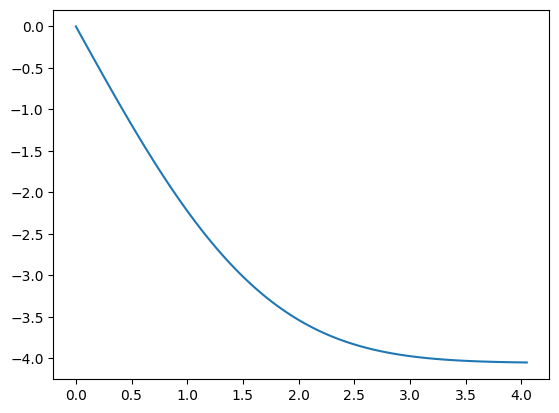

In [71]:
r = np.linspace(0, keplerian.r_max, 100)
R = keplerian._B * np.sqrt(1 - np.exp(-2 * (r / keplerian.omega_0)**2))

plt.figure()
plt.plot(r, R)
plt.show

print(R[-1])

### **Optimize**

LocalOpt = TheSystem.Tools.OpenLocalOptimization()
LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Automatic
LocalOpt.NumberOfCores = 8
LocalOpt.RunAndWaitForCompletion()
LocalOpt.Close()

# **Analysis**

In [4]:
TheAna = TheSystem.Analyses
num_analyses = TheAna.NumberOfAnalyses
print(num_analyses)
#help(TheAna)

1


In [8]:
for i in range(1, num_analyses+1): 
    ana = TheAna.Get_AnalysisAtIndex(i)
    print(f"Analysis {i}: {ana.GetAnalysisName}")

Analysis 1: GeometricImageAnalysis


In [6]:
#TheAna.CloseAnalysis(1)
#TheAna.CloseAnalysis(2)
TheAna.New_GeometricImageAnalysis()

In [9]:
GeoImgAna = TheAna.Get_AnalysisAtIndex(1)
GeoImgAna.GetAnalysisName
#help(GeoImgAna)

'GeometricImageAnalysis'

In [10]:
GIA_Settings = GeoImgAna.GetSettings()
# help(GIA_Settings)

In [11]:
GIA_Settings.NumberOfPixels = 200

In [12]:
GIA_Settings.Surface.SetSurfaceNumber(-1)
print(GIA_Settings.Surface.GetSurfaceNumber())
#help(GIA_Settings.Surface)

-1


In [14]:
print(GIA_Settings.RaysX1000)
GIA_Settings.RaysX1000 = 500000
#help(GIA_Settings.RaysX1000)

500000


In [16]:
print(GIA_Settings.ImageSize)
GIA_Settings.ImageSize = 10.0
#help(GIA_Settings.ImageSize)

10.0


In [18]:
# ShowAsTypes: Surface, Contour, GreyScale, InverseGreyScale, FalseColor, InverseFalseColor, SpotDiagram, CrossX, CrossY
GIA_Settings.ShowAs = ZOSAPI.Analysis.GiaShowAsTypes.CrossX
GIA_Settings.get_ShowAs()

7

In [82]:
# Doesn't work
GIA_Settings.UpdateUI

<bound method 'UpdateUI'>

In [19]:
GeoImgAna.ApplyAndWaitForCompletion()

In [84]:
#GeoImgAna.Terminate()

## **Results**

In [20]:
# Only get2D pixel Values
GIA_Results = GeoImgAna.GetResults()
#help(GIA_Results)

In [21]:
print(GIA_Results.NumberOfDataGrids)
data1 = GIA_Results.DataGrids[0]
 #help(data1)

1


40000
x: 200
y: 200


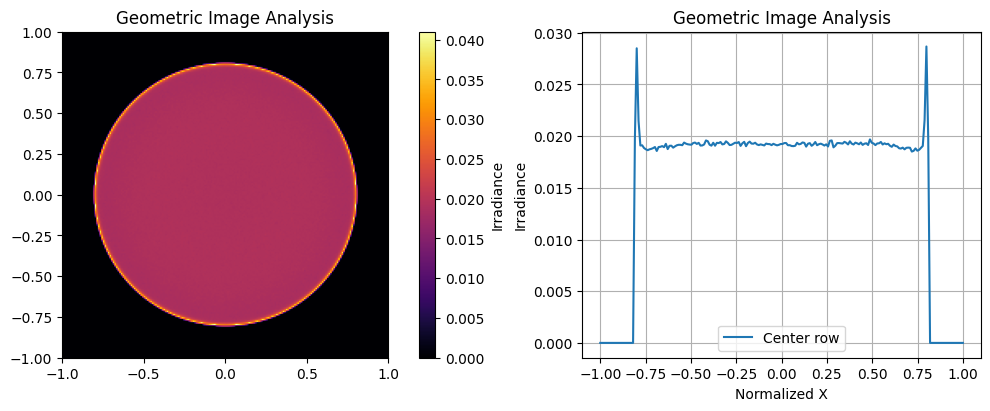

In [22]:
#help(data1.Values)
print(data1.Values.Length)
print("x:", data1.Values.GetLength(0))
print("y:", data1.Values.GetLength(1))
zos.gia_plots(data1.Values, data1.Values.GetLength(0), data1.Values.GetLength(1), transpose=False)